# Paolina functions
For development and testing of IC-based Paolina

In [1]:
%matplotlib inline

from __future__ import print_function
import abc
import pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.patches import Ellipse

from   collections import namedtuple
from   invisible_cities.database import load_db
from   invisible_cities.core.system_of_units_c import units

import random
import tables as tb
import numpy as np
import tensorflow as tf
import networkx as nx

NSIPM = 1792

------
## Test events
Read in using old PMap format, converted to a format to be passed to reconstruction method.

In [2]:
nfile = "/Users/jrenner/IFIC/jerenner/ICARO/invisible_cities/utils/hdf5_NEXT_NEW_se_1M_v0_08_07_0.h5"
erange_low = 0
erange_high = 10

In [3]:
# plot a 48x48 SiPM map
# -- carried over from NEW_kr_diff_mc_train.ipynb
def plot_test_event(l_X,l_Y,l_Q):
    """
    Plots a SiPM map in the NEW Geometry
    """

    # set up the figure
    fig = plt.figure();
    ax1 = fig.add_subplot(111);
    fig.set_figheight(10.0)
    fig.set_figwidth(10.0)
    ax1.axis([-250, 250, -250, 250]);

    # plot the SiPM pattern
    for xx,yy,qq in zip(l_X,l_Y,l_Q):
        r = Ellipse(xy=(xx, yy), width=2., height=2.);
        r.set_facecolor('0');
        r.set_alpha(qq);
        ax1.add_artist(r);

    # place a large blue circle for actual EL points
    #if(hasattr(l_X0, "__len__")):
    #    for xx,yy in zip(l_X0,l_Y0):
    #        mrk = Ellipse(xy=(xx,yy), width=4., height=4.)
    #        mrk.set_facecolor('b')
    #        ax1.add_artist(mrk)
    #else:
    #    mrk = Ellipse(xy=(l_X0,l_Y0), width=4., height=4.)
    #    mrk.set_facecolor('b')
    #    ax1.add_artist(mrk)
        
    # place a large red circle for reconstructed points
    #if(ept is not None):
    #    xpt = ept[0]*fscale - fshift*fscale
    #    ypt = ept[1]*fscale - fshift*fscale
    #    mrk = Ellipse(xy=(xpt,ypt), width=2., height=2.);
    #    mrk.set_facecolor('r');
    #    ax1.add_artist(mrk);
        
    plt.xlabel("x (mm)");
    plt.ylabel("y (mm)");

In [4]:
# load the SiPM (x,y) values
DataSensor = load_db.DataSiPM()
xs = DataSensor.X.values
ys = DataSensor.Y.values

# create (x,y) lists
_sipm_x = np.zeros(NSIPM)
_sipm_y = np.zeros(NSIPM)
for ID, x, y in zip(range(NSIPM), xs, ys):
    _sipm_x[ID] = x
    _sipm_y[ID] = y

In [5]:
nevts = erange_high - erange_low

# open the hdf5 file containing the PMaps.
fname = "{0}".format(nfile)
print("Opening file: {0}".format(fname))
fpmap = tb.open_file(fname,'r')
pmaps = fpmap.root.PMaps.PMaps
print(pmaps)

# set up the lists
tbl_T = []; tbl_E = [] 
tbl_X = []; tbl_Y = []; tbl_Q = []

# loop over all events.
rnum = 0                    # row number in table iteration
ev = 0                      # processed event number (starts at 0 and runs to nevts-1)
evtnum = pmaps[0]['event']  # event number from file
while(rnum < pmaps.nrows and ev < nevts):

    # Skip rows corresponding to event numbers outside of given range.
    if((evtnum < erange_low or evtnum > erange_high) and not (erange_low < 0 or erange_high < 0)):
        rnum += 1
        if(rnum < pmaps.nrows):
            evtnum = pmaps[rnum]['event']
        continue

    # Attempt to get all times, cathode energies, and anode values
    #  for one event.
    times = []
    cathodes = []
    anodes = []
    while(rnum < pmaps.nrows and pmaps[rnum]['event'] == evtnum):
        if(pmaps[rnum]['signal'] == b'S2'):
            times.append(pmaps[rnum]['time'])
            cathodes.append(pmaps[rnum]['cathode'])
            anodes.append(pmaps[rnum]['anode'])
        rnum += 1
        
    # convert to numpy arrays
    anodes = np.array(anodes)
    cathodes = np.array(cathodes)
    times = np.array(times)

    # if we had an S2 for this event, get the relevant information and add the event
    if(len(times) > 0):
        print("Had S2")
        
        # store the energies and times of each projection
        tbl_E.append(cathodes)
        tbl_T.append(times)
        
        # create lists of (x,y,q) for each projection and store
        evt_X = []; evt_Y = []; evt_Q = []
        for aa in anodes:
            ids = np.nonzero(aa)
            evt_X.append(_sipm_x[ids])
            evt_Y.append(_sipm_y[ids])
            evt_Q.append(aa[ids])
        tbl_X.append(evt_X)
        tbl_Y.append(evt_Y)
        tbl_Q.append(evt_Q)

    # set to the next event
    if(rnum < pmaps.nrows):
        print("Processed event {0} with rnum {1} of {2} rows.".format(evtnum, rnum, pmaps.nrows))
        evtnum = pmaps[rnum]['event']
        
# convert to arrays
tbl_X = np.array(tbl_X)
tbl_Y = np.array(tbl_Y)
tbl_Q = np.array(tbl_Q)

Opening file: /Users/jrenner/IFIC/jerenner/ICARO/invisible_cities/utils/hdf5_NEXT_NEW_se_1M_v0_08_07_0.h5
/PMaps/PMaps (Table(144354,), shuffle, zlib(9)) 'PMaps'
Had S2
Processed event 2 with rnum 34 of 144354 rows.
Had S2
Processed event 3 with rnum 94 of 144354 rows.
Had S2
Processed event 4 with rnum 142 of 144354 rows.
Had S2
Processed event 5 with rnum 190 of 144354 rows.
Had S2
Processed event 9 with rnum 258 of 144354 rows.
Had S2
Processed event 10 with rnum 324 of 144354 rows.


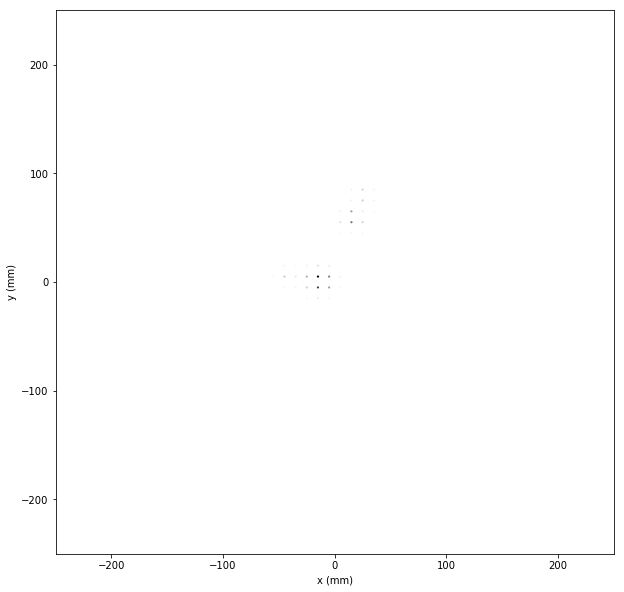

In [6]:
# plot a test projection
t_evt = 0; t_proj = 14
t_X = tbl_X[t_evt][t_proj]; t_Y = tbl_Y[t_evt][t_proj]
t_Q = tbl_Q[t_evt][t_proj]
t_Q /= np.max(t_Q)

plot_test_event(t_X,t_Y,t_Q)

-------
# Reconstruction

In [7]:
# event to be reconstructed
r_evt = 0

In [8]:
# reconstruction objects (already defined)
class Event:
    def __init__(self):
        self.evt  = -1
        self.time = -1

    def __str__(self):
        s = "{0}Event\n{0}".format("#"*20 + "\n")
        for attr in self.__dict__:
            s += "{}: {}\n".format(attr, getattr(self, attr))
        return s

    def copy(self, other):
        assert isinstance(other, Event)
        for attr in other.__dict__:
            setattr(self, attr, copy.deepcopy(getattr(other, attr)))

    @abc.abstractmethod
    def store(self, *args, **kwargs):
        pass

class Hit:
    def __init__(self):
        self.Npeak = -1
        self.X     = -1e12
        self.Y     = -1e12
        self.R     = -1e12
        self.Phi   = -1e12
        self.Z     = -1
        self.E     = -1
        self.Q     = -1
        self.Nsipm = -1

class HitCollection(list, Event):
    def __init__(self):
        list .__init__(self)
        Event.__init__(self)

    def store(self, row):
        for hit in self:
            row["event"] = self.evt
            row["time" ] = self.time

            row["npeak"] = hit.Npeak
            row["X"    ] = hit.X
            row["Y"    ] = hit.Y
            row["Z"    ] = hit.Z
            row["R"    ] = hit.R
            row["Phi"  ] = hit.Phi
            row["Nsipm"] = hit.Nsipm
            row["Q"    ] = hit.Q
            row["E"    ] = hit.E
            row["Ecorr"] = hit.Ecorr

            row.append()

# cluster named tuple (make the class using the namedtuple function)
Cluster = namedtuple('Cluster', 'Q X Y Xrms Yrms Nsipm')

In [9]:
# from xy_algorithms.py (Gonzalo)
def barycenter(xs, ys, qs, default=np.nan):
    q    = np.sum(qs)
    n    = len(qs)
    x    = np.average(xs, weights=qs)         if n and q>0 else default
    y    = np.average(ys, weights=qs)         if n and q>0 else default
    xvar = np.sum(qs * (xs - x)**2) / (q - 1) if n and q>0 else default
    yvar = np.sum(qs * (ys - y)**2) / (q - 1) if n and q>0 else default

    c    = Cluster(q, x, y, xvar**0.5, yvar**0.5, n)
    return c

In [10]:
def reco_algorithm(xs, ys, Qs, rmax=30*units.mm, T=3.5*units.pes):
    """
    rmax is the maximum radius of a cluster
    T is the threshold for local maxima (this kwarg may be unnecessary)
    returns a list of Clusters
    """
    c = []
    xs = np.copy(xs)
    ys = np.copy(ys)
    qs = np.copy(Qs)

    # While there are more local maxima
    while len(qs) > 0:
        i_max = np.argmax(qs)    # SiPM with largest Q
        if qs[i_max] < T: break  # largest Q remaining is negligible

        # get SiPMs within rmax of SiPM with largest Q
        dists = np.sqrt((xs - xs[i_max]) ** 2 + (ys - ys[i_max]) ** 2)
        cluster = np.where(dists < rmax)[0]

        # get barycenter of this cluster
        c.append(barycenter(xs[cluster], ys[cluster], qs[cluster]))

        xs = np.delete(xs, cluster) # delete the SiPMs
        ys = np.delete(ys, cluster) # contributing to
        qs = np.delete(qs, cluster) # this cluster

    return c

In [11]:
# different than Gonzalo's because we're using our test setup
def compute_xy_position(xs,ys,Qs):
    return reco_algorithm(xs, ys, Qs)

In [12]:
# split the energy across the clusters
def split_energy(Es, clusters):
    qtot = np.sum([cl.Q for cl in clusters])
    return [(Es*cl.Q/qtot) for cl in clusters]

In [44]:
# reconstruct the entire event
e_X = tbl_X[r_evt]
e_Y = tbl_Y[r_evt]
e_T = tbl_T[r_evt]
e_E = tbl_E[r_evt]
e_Q = tbl_Q[r_evt]

# set up the HitCollection
hitc = HitCollection()
hitc.evt   = r_evt
hitc.time  = 0

# iterate through all slices
for Xs,Ys,Ts,Es,Qs in zip(e_X,e_Y,e_T,e_E,e_Q):
    clusters = compute_xy_position(Xs,Ys,Qs)
    es       = split_energy(Es, clusters)
    z        = (Ts - 0.0) * 1000.0 / 1000.0  #(t_slice - S1t) * units.ns * self.drift_v
    print("z is {0}".format(z))
    for c, e in zip(clusters, es):
        hit       = Hit()
        hit.Npeak = 0 #npeak
        hit.X     = c.X
        hit.Y     = c.Y
        hit.R     = (c.X**2 + c.Y**2)**0.5
        hit.Phi   = np.arctan2(c.Y, c.X)
        hit.Z     = z
        hit.Q     = c.Q
        hit.E     = e
        hit.Ecorr = e #correct_energy(e, c.X, c.Y, z)
        hit.Nsipm = c.Nsipm
        hitc.append(hit)

z is 212.0
z is 213.0
z is 214.0
z is 215.0
z is 216.0
z is 217.0
z is 218.0
z is 219.0
z is 220.0
z is 221.0
z is 222.0
z is 223.0
z is 224.0
z is 225.0
z is 226.0
z is 227.0
z is 228.0
z is 229.0
z is 230.0
z is 231.0
z is 232.0
z is 233.0
z is 234.0
z is 235.0
z is 236.0
z is 237.0
z is 238.0
z is 239.0
z is 240.0
z is 241.0
z is 242.0
z is 243.0
z is 244.0


---------
# Paolina algorithm
At this point the hit collection for an event should be in the variable `hitc`.

In [60]:
# variables we need to set initially
vol_min = np.array([-250, -250, 0])  # volume minimum (x,y,z)
vol_max = np.array([250, 250, 800])  # volume maximum (x,y,z)
vox_size = np.array([10, 10, 5])    # voxel size
blob_radius = 15.                    # blob radius in mm

In [61]:
# define voxel object
Voxel = namedtuple('Voxel', 'ID X Y Z E ix iy iz size_x size_y size_z')

In [79]:
def build_voxels(hitc):
    """Builds a list of voxels from the specified hit collection.
    """
    
    # calculate the size of the volume dimensions
    vdim = vol_max - vol_min
    
    # create the voxel array
    varr = np.zeros([vdim[0],vdim[1],vdim[2]])
    
    # add the energy of all hits to the voxels
    for hh in hitc:
        ivox = int((hh.X - vol_min[0]) / vox_size[0])
        jvox = int((hh.Y - vol_min[1]) / vox_size[1])
        kvox = int((hh.Z - vol_min[2]) / vox_size[2])
        varr[ivox][jvox][kvox] += hh.E

    # get lists of the nonzero x,y,z indices and E values
    nzx,nzy,nzz = np.nonzero(varr)
    nze = varr[np.nonzero(varr)]
    
    # create voxel objects
    voxelc = []; vid = 0
    for ix,iy,iz,ee in zip(nzx,nzy,nzz,nze):
        voxelc.append(Voxel(vid,
                            vol_min[0] + x*vox_size[0],
                            vol_min[1] + y*vox_size[1],
                            vol_min[2] + z*vox_size[2],
                            ee, ix, iy, iz,
                            vox_size[0],vox_size[1],vox_size[2]))
        print("Added voxel {0},{1},{2} with {3}".format(ix,iy,iz,ee))
        vid += 1
        
    return voxelc

In [86]:
def calc_adj_matrix(voxelc):
    """Creates the adjacency matrix.
        -1         --> self
        0          --> not a neighbor
        (distance) --> voxels are neighbors    
    """
    # use the voxels: determine neighboring voxels by face, edge, or corner connections
    adj_mat = np.zeros([len(voxelc),len(voxelc)])

    # iterate through all voxels, and for each one find the neighboring voxels
    for vv1 in voxelc:
        for vv2 in voxelc:
            if(vv1.ix == vv2.ix and vv1.iy == vv2.iy and vv1.iz == vv2.iz):
                adj_mat[vv1.ID][vv2.ID] = -1.
            elif ((vv1.ix == vv2.ix+1 or vv1.ix == vv2.ix-1 or vv1.ix == vv2.ix) and 
                  (vv1.iy == vv2.iy+1 or vv1.iy == vv2.iy-1 or vv1.iy == vv2.iy) and 
                  (vv1.iz == vv2.iz+1 or vv1.iz == vv2.iz-1 or vv1.iz == vv2.iz)):
                adj_mat[vv1.ID][vv2.ID] = np.sqrt((vv2.X-vv1.X)**2 + (vv2.Y-vv1.Y)**2 + (vv2.Z-vv1.Z)**2)
                print("Found adjacency between voxels {0} and {1}".format(vv1.ID,vv2.ID))
        
    print("Adjacency matrix:")
    print(adj_mat)
    return adj_mat

In [87]:
def construct_tracks(voxelc,adj_mat):
    """Constructs all independent tracks given the list of voxels and adjacency matrix.
        Note: assumes the rows and columns of the adjacency matrix correspond
            to the voxels in the order that they are placed in voxelc
    """
    # add all voxels as nodes to a Graph
    pgraph = nx.Graph()
    pgraph.add_nodes_from(voxelc)
    print("Entire collection contains {0} voxels".format(len(voxelc)))
        
    # add edges connecting each node to its neighbor nodes based on the values in the adjacency matrix
    for nA in voxelc:
        for nB in voxelc:
            ndist = adj_mat[nA.ID][nB.ID]
            if(ndist > 0):
                print("-- Adding edge from {0} to {1} with weighting of {2}".format(nA.ID,nB.ID,ndist))
                pgraph.add_edge(nA,nB,weight=ndist)
    
    # find all independent tracks
    trks = []
    while(pgraph.number_of_nodes() > 0):
        
        # add all nodes with a path from node 0 to a single track
        tnodes = []; gnodes = pgraph.nodes()
        for nn in gnodes:
            if(nx.has_path(pgraph,gnodes[0],nn)):
                tnodes.append(nn)
        tgraph = nx.Graph()
        tgraph.add_nodes_from(tnodes)
        tgraph.add_edges_from(pgraph.edges(tnodes))
        trks.append(tgraph)
        
        # remove these nodes from the original graph and start again
        pgraph.remove_nodes_from(tnodes)
        
    # find the largest independent track
    itmax = max([trk.number_of_nodes() for trk in trks])
    print("Found {0} tracks with max having {1} nodes".format(len(trks),trks[itmax].number_of_nodes()))
    
    return (itmax,trks)

In [88]:
def calc_dist_mat(voxelc,pgraph):
    """Calculates the distance matrix and longest shortest path.
    """
    
    # initialize the distance matrix
    dist_mat = np.zeros([len(voxelc),len(voxelc)])
    
    # compute the matrix
    for n1,vv1 in enumerate(voxelc):
        for vv2 in voxelc[0:n1]:
            
            # calculate the length of the shortest path between these two voxels
            dist = nx.astar_path_length(pgraph,vv1,vv2)
            dist_mat[vv1.ID][vv2.ID] = dist_mat[vv2.ID][vv1.ID] = dist
    
    # compute one longest shortest path
    n1,n2 = np.unravel_index(np.argmax(dist_mat),dist_mat.shape)
    spath = nx.astar_path(pgraph,voxelc[n1],voxelc[n2])
    
    return (dist_mat,spath)

In [89]:
def construct_blobs(voxelc,dist_mat,spath):
    """Construct the blobs.
    """
    Eblob1 = Eblob2 = 0
    ext1 = spath[0]; ext2 = spath[-1]
    
    # add the energies of voxels within 1 blob radius of each extreme
    for vv in voxelc:
        dist1 = dist_mat[ext1.ID][vv.ID]
        if(dist1 < blob_radius):
            Eblob1 += vv.E
        dist2 = dist_mat[ext2.ID][vv.ID]
        if(dist2 < blob_radius):
            Eblob2 += vv.E

    return (Eblob1,Eblob2)

In [90]:
def paolina(hitc):
    """The Paolina reconstruction algorithm.
    
        returns:
        voxelc - a list of voxels in the track
        spath - the longest shortest path (as a sequence of voxels) in the track
        Eblob1 - the energy of the blob constructed about the first voxel in spath
        Eblob2 - the energy of the blob constructed about the last voxel in spath
    """
    voxelc = build_voxels(hitc)                                # voxelize the event
    adj_mat = calc_adj_matrix(voxelc)                          # calculate the adjacency matrix
    itmax,trks = construct_tracks(voxelc,adj_mat)                   # construct the graph
    dist_mat, spath = calc_dist_mat(voxelc,trks[itmax])             # calculate distance matrix and longest shortest path
    Eblob1, Eblob2 = construct_blobs(voxelc,dist_mat,spath)    # construct the blobs
    
    # return key quantities
    return (voxelc,spath,Eblob1,Eblob2)

In [91]:
# perform the Paolina algorithm
voxelc,spath,Eblob1,Eblob2 = paolina(hitc)

Added voxel 2,18,45 with 54.355186462402344
Added voxel 18,3,43 with 37.426753997802734
Added voxel 20,25,44 with 3719.2758560180664
Added voxel 20,25,45 with 500.6363525390625
Added voxel 21,25,45 with 5121.6748046875
Added voxel 21,25,47 with 318.5262641906738
Added voxel 22,25,46 with 6853.75927734375
Added voxel 22,26,46 with 16894.140625
Added voxel 22,26,47 with 7800.2333984375
Added voxel 22,27,46 with 1269.151611328125
Added voxel 22,27,47 with 848.6013793945312
Added voxel 22,28,47 with 2253.6923828125
Added voxel 23,24,44 with 697.0027465820312
Added voxel 23,25,45 with 83937.87231445312
Added voxel 23,25,47 with 12739.3310546875
Added voxel 23,27,47 with 11293.298828125
Added voxel 23,27,48 with 8673.073974609375
Added voxel 24,24,47 with 2323.2583618164062
Added voxel 24,25,45 with 64139.83203125
Added voxel 24,25,46 with 215279.8515625
Added voxel 24,25,47 with 30892.181640625
Added voxel 24,27,47 with 34509.1171875
Added voxel 25,25,46 with 68380.9765625
Added voxel 25,28

KeyError: Voxel(ID=1, X=2100.0, Y=-700.0, Z=1220.0, E=37.426753997802734, ix=18, iy=3, iz=43, size_x=10, size_y=10, size_z=5)